# Take-Home Challenge - Relax Inc. 

Relax Inc. makes productivity and project management software that's popular with both individuals and teams. Founded by several former Facebook employees

In [362]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import  warnings
warnings.simplefilter('ignore')

import datetime
import math
import datetime as dt

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import recall_score, precision_score
from sklearn import tree, metrics
from sklearn.tree import DecisionTreeClassifier

### Load the data

A  user  table  ( "takehome_users" )  with  data  on  12,000  users  who  signed  up  for  the
product  in  the  last  two  years.   This  table  includes:

● `name`:  the  user's  name

● `object_id`:   the  user's  id

● `email`:  email  address

● `creation_source`:   how  their  account  was  created.  This  takes  on  one of  5  values:

○ `PERSONAL_PROJECTS`:  invited  to  join  another  user's personal  workspace

○ `GUEST_INVITE`:  invited  to  an  organization  as  a  guest (limited  permissions)

○ `ORG_INVITE`:  invited  to  an  organization  (as  a  full  member)

○ `SIGNUP`:  signed  up  via  the  website

○ `SIGNUP_GOOGLE_AUTH`:  signed  up  using  Google

Authentication  (using  a  Google  email  account  for  their  login id)

● `creation_time`:  when  they  created  their  account

● `last_session_creation_time`:   unix  timestamp  of  last  login

● `opted_in_to_mailing_list`:  whether  they  have  opted  into  receiving marketing  emails

● `enabled_for_marketing_drip`:  whether  they  are  on  the  regular marketing  email  drip

● `org_id`:   the  organization  (group  of  users)  they  belong  to

● `invited_by_user_id`:   which  user  invited  them  to  join  (if  applicable).

In [363]:
users = pd.read_csv(".\\takehome_users.csv", encoding='latin-1')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [364]:
users.loc[users['object_id'] == 1693]

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
1692,1693,2012-05-31 21:58:33,Faulkner Hayden,HaydenFaulkner@gmail.com,SIGNUP_GOOGLE_AUTH,1.399932e+09,0,1,50,NaN


### Load Data 2: 
A  usage  summary  table  ( `"takehome_user_engagement"` )  that  has  a  row  for  each  day
that  a  user  logged  into  the  product.

In [365]:
user_engagement = pd.read_csv(".\\takehome_user_engagement.csv", encoding='latin-1', parse_dates=True)
user_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [366]:
user_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


## Data Wrangling

In [367]:
user_engagement.isnull().sum()

time_stamp    0
user_id       0
visited       0
dtype: int64

In [368]:
users.isnull().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

There are missing values for `last_session_creation_time` and `invited_by_user_id`. There are no missing values in the engagement dataframe. We first fill the missing values in `invited_by_user_id` with zero.

In [369]:
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(0)

In [370]:
#now set that to datetime (don't forget to use unit='s')
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [371]:
users['last_session_creation_time'] = users['last_session_creation_time'].fillna(users['creation_time'])

#### Adopted  user

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven­day  period ,  identify  which  factors  predict  future  user
adoption .


In [372]:
import datetime

#set the time_stamp to datetime and the set it as the index
user_engagement.time_stamp = pd.to_datetime(user_engagement.time_stamp)
user_engagement = user_engagement.set_index('time_stamp', drop= True)

In [373]:
from datetime import timedelta

def label_adopted(x):    
    "takes a users input and returns whether or not they have been active within any 7-day period"
    df_temp = user_engagement.loc[user_engagement['user_id'] == x] #select out rows of this user
    df_temp = df_temp.resample('D').mean().dropna() #resample to show if active in a day. .mean() is just of 1
    adopted = 0
    for i in range(len(df_temp)-2): #loop over active days till the second to last day
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [374]:
#apply to user df to label users as adopted=true 
users['adopted_user'] = users['object_id'].apply(label_adopted)

In [375]:
print(sum(users['adopted_user']))
print(sum(users.adopted_user)/len(users.adopted_user))

1656
0.138


In [376]:
print("Total number of engaged users: {}".format(user_engagement.user_id.nunique()))

Total number of engaged users: 8823


In [387]:
type(user_engagement)

pandas.core.frame.DataFrame

In [388]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0


In [398]:
adopted = users[users["adopted_user"] == 1]
not_adopted = users[users["adopted_user"] == 0]

In [400]:
print("adopted : ", X.shape)
print("not_adopted : ", y.shape)

adopted :  (1656, 11)
not_adopted :  (10344, 11)


In [401]:
users['email_domain'] = [x.split('@')[1] for x in users.email] 
top3_domains = users.email_domain.value_counts().index[:3] # top 3 domains
print("Top 3 domains: {}".format(top3_domains))
users['email_domain'] = [x if x in top3_domains else "other" for x in users.email_domain]

Top 3 domains: Index(['gmail.com', 'yahoo.com', 'jourrapide.com'], dtype='object')


In [403]:
users.head(2)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,email_domain
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,yahoo.com
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1,other


#### Feature Encoding

In [406]:
categorical_feature_mask = X.dtypes==np.object
# filter categorical columns using mask and turn it into a list
categorical_cols = X.columns[categorical_feature_mask].tolist()

In [407]:
from sklearn.preprocessing import LabelEncoder

no_need_cols = ['object_id', 'creation_time', 'name', 'email', 'last_session_creation_time', 
                    'org_id', 'invited_by_user_id', 'adopted_user']
                
y = users.adopted_user
X = users.drop(no_need_cols, axis=1)

In [408]:
X_encoded_getdummies = pd.get_dummies(X, columns = categorical_cols, prefix_sep='_', drop_first=True) 

In [410]:
X = X_encoded_getdummies
y = users.adopted_user

In [411]:
from sklearn.model_selection import train_test_split

X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [412]:
from sklearn.ensemble import RandomForestClassifier

#train and test classifier
rf_clf = RandomForestClassifier()

rf_clf.fit(X_train, X_test)

rf_clf.score(y_train, y_test)

0.8603535353535353

In [415]:
from sklearn.metrics import classification_report, confusion_matrix

#print out classification report and confusion matrix
y_pred = rf_clf.predict(y_train)

print(classification_report(y_test, y_pred))

cm= confusion_matrix(y_test,y_pred)
print('confusion matrix:')
print(cm)

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      3407
           1       0.00      0.00      0.00       553

    accuracy                           0.86      3960
   macro avg       0.43      0.50      0.46      3960
weighted avg       0.74      0.86      0.80      3960

confusion matrix:
[[3407    0]
 [ 553    0]]


In [423]:
print(f"accuracy_score:  {accuracy_score(y_test, y_pred)* 100}")

accuracy_score:  86.03535353535354


In [425]:

from xgboost import XGBClassifier
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
# fit model to training data
model = XGBClassifier()
model.fit(X_train, y_train)

[13:21:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [427]:
# Predictions on the test set
XgB_test_pred = model.predict(X_test)

In [428]:
print(f"accuracy_score:  {accuracy_score(y_test, XgB_test_pred)* 100}")

accuracy_score:  86.31313131313131


Text(0, 0.5, 'Feature Importance Score')

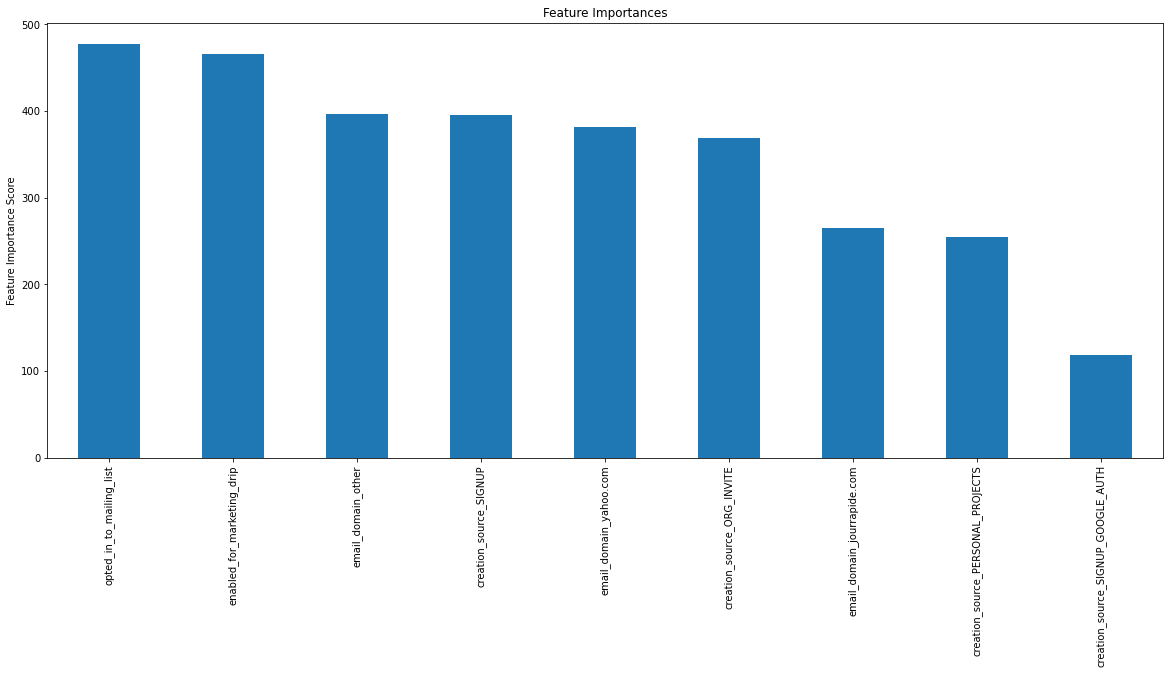

In [430]:
plt.figure(figsize=(20,8))
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

### Conclusion:
Random Forest Classifier and XGBoost model can predict an active user with 86% accuracy.